In [306]:
%pylab inline
%run params.py

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from scipy.stats import pearsonr
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from plotting_functions import *
from scipy.stats import ks_2samp
import random

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [307]:
dataset = pd.read_csv(os.path.join(DATAPATH, "constraint", "autosomal_perlocus_estimates.bed"))

# 3D STRsets

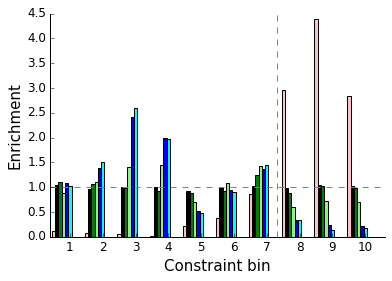

In [308]:
# Enrichment by bin
perc = 10
col = "zscore_1"
zbins = np.percentile(dataset[col], np.arange(0, 101, perc))
midpt = min([i for i in range(len(zbins)) if zbins[i] > 0])

fig = plt.figure()
ax = fig.add_subplot(111)

# For each set, get fold enrichment in each bin
strsets = ["eSTRs.bed",
           "lobSTR_ref_GRCh37_intron.bed",
           "lobSTR_ref_GRCh37_3utr.bed",
           "lobSTR_ref_GRCh37_5utr.bed",
           "lobSTR_ref_GRCh37_coding.bed",
          "lobSTR_ref_GRCh37_missenseconstrained.bed"]
colors = ["pink","black","green","lightgreen","blue","cyan"]

xvals = np.arange(len(zbins)-1)  # the x locations for the groups
width = 0.10       # the width of the bars
ind = 0
labels = []
for strset in strsets:
    vals = []
    label = strset.split(".bed")[0].split("_")[-1]
    if label == "IDgenes":
        names = ["chrom","start","end","gene"]
    else: names = ["chrom","start","end"]
    if "missense" in label: label = "missense"
    setdata = pd.read_csv(os.path.join(DATAPATH, "strsets", strset+".gz"), sep="\t", names=names)
    setdata = pd.merge(setdata, dataset, on=["chrom","start"]).drop_duplicates()
    for i in range(len(zbins)-1):
        lb = zbins[i]
        ub = zbins[i+1]
        inbin = setdata[(setdata[col]>=lb) & (setdata[col]<ub)].shape[0]
        outbin = setdata.shape[0] - inbin
        enrich = (inbin*1.0/perc) / (outbin*1.0/(100-perc))
        #print strset, lb, ub, inbin, np.log10(enrich)
        vals.append(enrich)
    ax.bar(xvals + ind*width, vals, width=width, color=colors[ind], align="center")
    ind += 1
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_xticks(map(lambda x: x+0.5, range(len(zbins)-1)))
ax.set_xticklabels(range(1, len(zbins)), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.set_xlim(left=-0.1, right=len(vals)+0.1)
ax.axhline(1, linestyle="dashed", color="gray");
ax.axvline(midpt-1.2, linestyle="dashed", color="gray")
ax.set_xlabel("Constraint bin", size=15);
ax.set_ylabel("Enrichment", size=15);
fig.savefig(os.path.join(PLOTDIR, "Figure3_ConstraintBins.pdf"))

In [297]:
# Look at expression by tissue
gtex = pd.read_csv(os.path.join(DATAPATH,"strsets","GTEx_Analysis_v6p_RNA-seq_RNA-SeQCv1.1.8_gene_median_rpkm.gct.gz"),
                  skiprows=2, sep="\t")
exprcols = [item for item in gtex.columns if item not in ["Description","Name"]]
gtex["gene"] = gtex["Description"]

setdata = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
setdata = pd.merge(setdata, dataset, on=["chrom","start"]).drop_duplicates()
data = pd.merge(setdata, gtex, on=["gene"])
exprmatrix = data.loc[:,exprcols]

In [303]:
col="zscore_1"

corr = []
pvals = []
means = []
nums = []
kspvals = []
kspvals_ctrl = []
threshold = 5 # top X% of expressed genes

for tissue in exprcols:
    r = pearsonr(data[data[tissue]>0][col], data[data[tissue]>0][tissue])
    corr.append(r[0])
    pvals.append(r[1])
    means.append(np.mean(data[data[tissue]>0][col]))
    nums.append(data[data[tissue]>0].shape[0])
    
    # zscores for top 10%
    cutoff = np.percentile(data[tissue], [threshold])[0]
    zhigh = data[data[tissue]>cutoff][col]
    zlow = data[data[tissue]<=cutoff][col]
    kspvals.append(ks_2samp(zhigh, zlow)[1])
    
    # Repeat, with expression shuffled
    rexpr = data[tissue].copy()
    random.shuffle(rexpr)
    zhigh = data[rexpr>cutoff][col]
    zlow = data[rexpr<=cutoff][col]
    kspvals_ctrl.append(ks_2samp(zhigh, zlow)[1])    
    
cdata = pd.DataFrame({"tissue": exprcols, "corr": corr, "pval": pvals, "meanz": means,"num":nums,
                      "ksp":kspvals, "ksp_ctrl": kspvals_ctrl})
cdata["corr2"] = cdata["corr"].apply(lambda x: x**2)
cdata = cdata[["tissue","corr","corr2","pval","meanz","num","ksp","ksp_ctrl"]]

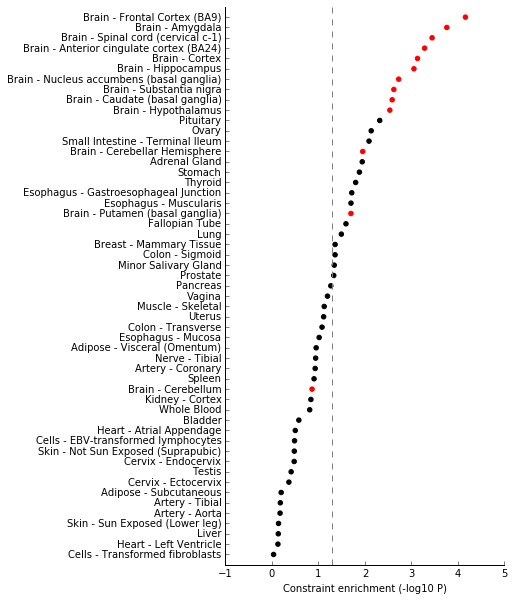

In [304]:
colors = {}
for tissue in exprcols:
    if "Brain" in tissue: colors[tissue] = "red"

cdata["color"] = cdata["tissue"].apply(lambda x: colors.get(x, "black"))
cdata = cdata.sort("ksp", ascending=False)
cdata["order"] = range(cdata.shape[0])
fig = plt.figure()
fig.set_size_inches((5,10))
ax = fig.add_subplot(111)
ax.scatter(np.log10(cdata["ksp"])*-1, cdata["order"], color=cdata["color"])
ax.axvline(x=-1*np.log10(0.05), linestyle="dashed", color="gray")
ax.set_ylim(bottom=-1, top=cdata.shape[0])
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_yticks(cdata["order"])
ax.set_yticklabels(cdata["tissue"]);
ax.set_xlabel("Constraint enrichment (-log10 P)")
fig.savefig(os.path.join(PLOTDIR, "Figure4_ConstraintExpression.pdf"))

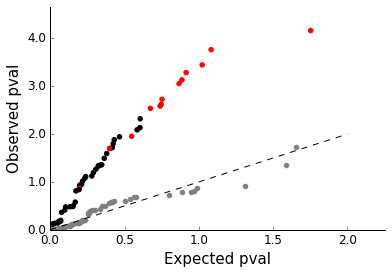

In [305]:
cdata = cdata.sort("ksp_ctrl")
ctrl = -1*np.log10(cdata["ksp_ctrl"])
exp2 = -1*np.log10(sorted(np.random.uniform(size=cdata.shape[0])))
cdata = cdata.sort("ksp")
exp = -1*np.log10(sorted(np.random.uniform(size=cdata.shape[0])))
obs = -1*np.log10(cdata["ksp"])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(exp, obs, color=cdata["color"])
ax.scatter(exp2, ctrl, color="gray")
ax.plot([0,2],[0,2], color="black", linestyle="dashed")
ax.set_xlim(left=0, right=max(exp)+0.5)
ax.set_ylim(bottom=0, top=max(obs)+0.5)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_xlabel("Expected pval", size=15)
ax.set_ylabel("Observed pval", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);